Connected to Python 3.10.0

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
# define a transformation for converting to tensor and normalizing
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean=0.5, std=0.5
])

# download FashionMNIST training and test datasets from torchvision
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

# create data loaders for training and testing
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

100%|██████████| 26.4M/26.4M [00:15<00:00, 1.75MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 155kB/s]
100%|██████████| 4.42M/4.42M [00:03<00:00, 1.36MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.65MB/s]


In [ ]:
print(train_data.data.shape) # (60000, 28, 28)
print(test_data.data.shape) # (60000,)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNNTorch(nn.Module):
    def __init__(self):
        super(CNNTorch, self).__init__()
        
        # convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)  # 28x28 → 28x28
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # 14x14 → 14x14 after pooling

        # maxpooling layer halves the height/width
        self.pool = nn.MaxPool2d(2, 2)  

        # fully connected layers
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # 7x7 from 28 → 14 → 7
        self.fc2 = nn.Linear(128, 10)  # 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (B,16,28,28) → (B,16,14,14)
        x = self.pool(F.relu(self.conv2(x)))  # (B,32,14,14) → (B,32,7,7)
        x = x.view(-1, 32 * 7 * 7)  # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # logits (no softmax)
        return x

In [ ]:
import torch.optim as optim

# initialize model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNTorch().to(device)

# using Adam optimizer and cross entropy loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# training loop 
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # pass images through model to get outputs forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backpropagating the loss and updating the weights 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.4f}")

Epoch [1/5], Loss: 447.3794
Epoch [2/5], Loss: 289.1780
Epoch [3/5], Loss: 245.1323
Epoch [4/5], Loss: 219.0491
Epoch [5/5], Loss: 195.7015


In [ ]:
# testing the model
model.eval()  # set model to eval mode to disable gradient tracking
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Test Accuracy was: 90.51%
print(f"Test Accuracy: {100 * correct / total:.2f}%")# %%

Test Accuracy: 90.51%


In [ ]:
# save the model weights only to reload later
torch.save(model.state_dict(), f"data/fashion_cnn_weights_{epochs}.pth")

In [ ]:
# load the model
# model = CNNTorch()
# model.load_state_dict(torch.load("data/fashion_cnn_weights.pth"))
# model.eval()

In [ ]:
# for saving the model, you can save the entire model too
# torch.save(model, f"data/fashion_cnn_model_{epochs}.pth")
# model = torch.load("data/fashion_cnn_model_{epochs}.pth")
# model.eval()

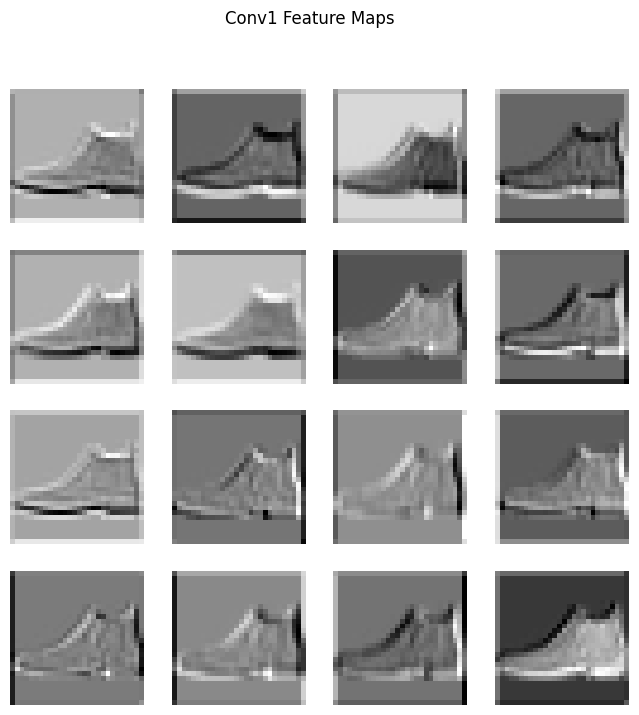

In [ ]:
# %%

import matplotlib.pyplot as plt

# Pick an example image
images, _ = next(iter(test_loader))
img = images[0].unsqueeze(0).to(device)  # shape: (1, 1, 28, 28)

# Hook to grab outputs
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register hooks
model.conv1.register_forward_hook(get_activation('conv1'))
model.conv2.register_forward_hook(get_activation('conv2'))

# Forward pass
_ = model(img)

# Plot feature maps from conv1
act = activation['conv1'].squeeze()  # shape: (16, 28, 28)
fig, axarr = plt.subplots(4, 4, figsize=(8, 8))
for idx in range(16):
    axarr[idx//4, idx%4].imshow(act[idx].cpu(), cmap='gray')
    axarr[idx//4, idx%4].axis('off')
plt.suptitle("Conv1 Feature Maps")
plt.show()

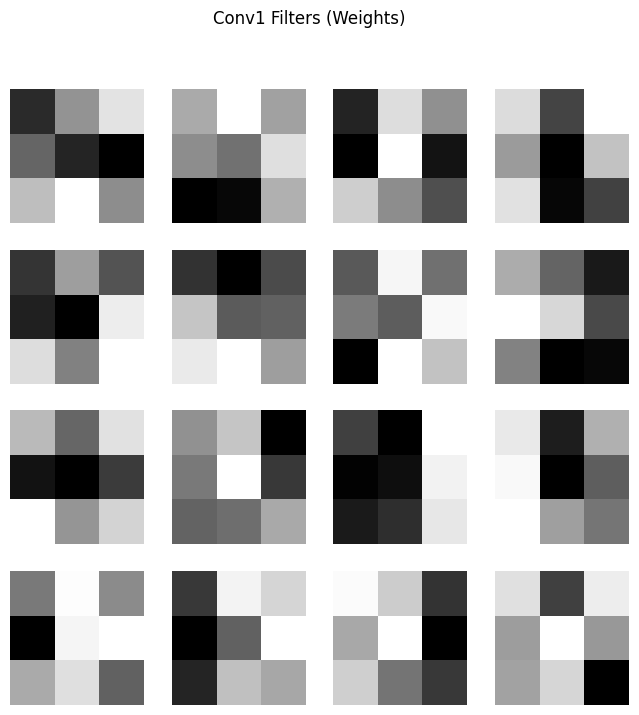

In [ ]:
# %%

# Get weights of conv1: shape = (out_channels, in_channels, k, k)
filters = model.conv1.weight.data.clone().cpu()

fig, axarr = plt.subplots(4, 4, figsize=(8, 8))
for idx in range(16):
    axarr[idx//4, idx%4].imshow(filters[idx][0], cmap='gray')  # single input channel
    axarr[idx//4, idx%4].axis('off')
plt.suptitle("Conv1 Filters (Weights)")
plt.show()

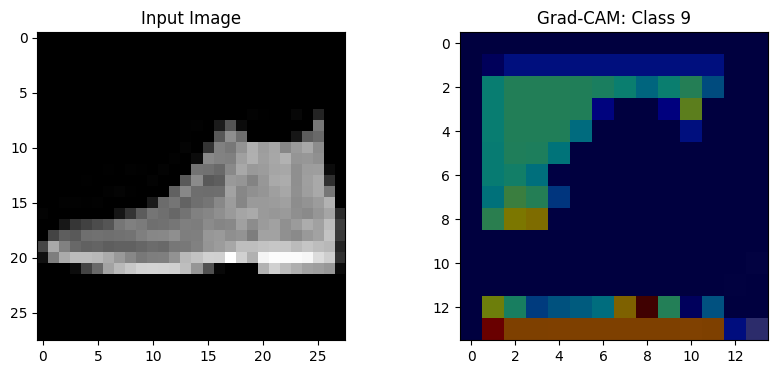

In [ ]:
# %%

from torchcam.methods import GradCAM
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

# Pick an image and label
images, labels = next(iter(test_loader))
img = images[0].unsqueeze(0).to(device)

# Re-enable gradients for inference
model.eval()

# Initialize GradCAM on final conv layer
cam_extractor = GradCAM(model, target_layer='conv2')

# Forward pass
out = model(img)
pred_class = out.argmax().item()

# Generate CAM for predicted class
activation_map = cam_extractor(pred_class, out)

# Overlay the heatmap
heatmap = activation_map[0].squeeze().cpu()
input_image = img.squeeze().cpu()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap="gray")
plt.title("Input Image")

plt.subplot(1, 2, 2)
plt.imshow(input_image, cmap="gray")
plt.imshow(heatmap, cmap="jet", alpha=0.5)
plt.title(f"Grad-CAM: Class {pred_class}")
plt.show()

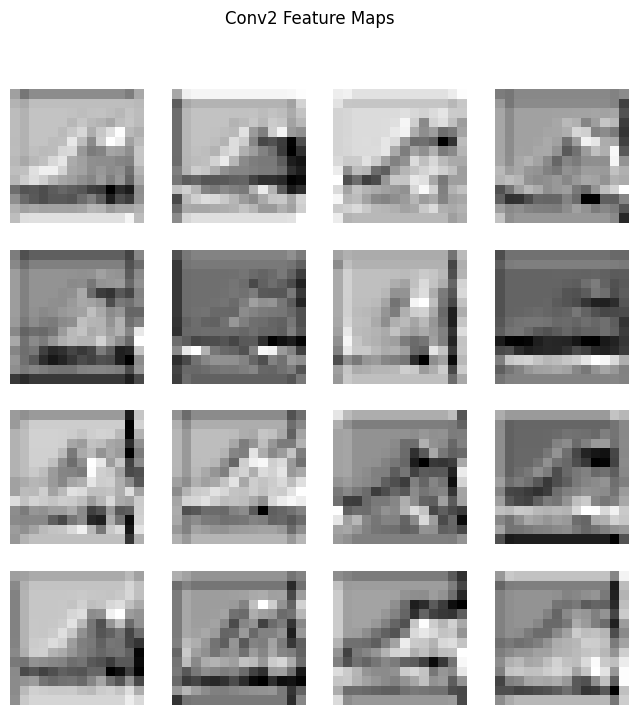

In [ ]:
# %%

import matplotlib.pyplot as plt

# Pick an example image
images, _ = next(iter(test_loader))
img = images[0].unsqueeze(0).to(device)  # shape: (1, 1, 28, 28)

# Hook to grab outputs
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register hooks
model.conv1.register_forward_hook(get_activation('conv1'))
model.conv2.register_forward_hook(get_activation('conv2'))

# Forward pass
_ = model(img)

# Plot feature maps from conv1
act = activation['conv2'].squeeze()  # shape: (16, 28, 28)
fig, axarr = plt.subplots(4, 4, figsize=(8, 8))
for idx in range(16):
    axarr[idx//4, idx%4].imshow(act[idx].cpu(), cmap='gray')
    axarr[idx//4, idx%4].axis('off')
plt.suptitle("Conv2 Feature Maps")
plt.show()